# Panoptic -- Takehome assignment

Here we present a brief solution of panoptic's takehome assignment. The goial of this assignment is to perform an analysis of the data included in the ETH-USDC pool with a fee at 5 basis points (bps). The raw data for this task can found [here](https://drive.google.com/open?id=1u7kdOZD9t0cA9Gm_njhSP62vfzX-PP8M&authuser=2) 
This data should be stored in a folder 'data'
We begin by importing the required libraries. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import datetime
import math



try:
    plt.style.use('stylesheet/panoptic-dark-7:8.mplstyle')
    print("☑️ using panoptic's matplotlib backend.")


except:
    print("⚠️ There was an issue importing panoptic's matplotlib stylesheet.")
    print("   Make sure you have them on a local folder called 'stylesheet' ")
    print("   Defaulting to Solarize ligght 2 which is slightly less ugly than the default... ") 
    plt.style.use('Solarize_Light2')




☑️ using panoptic's matplotlib backend.


#### Q0: Preparation

Before proceeding to download and analyse such a data, we first present an exemplary `Python` class that that we call `computePool` that can help us address questions 1 through 4.

- Questions 1 and 2 will rely upon, mostly, The main component of such a code is the `runStrategy(position:dict,updateFreq:int)` method, which computes the return fora strategy that redeploys a UNIV3 position every `updateFreq` days. The majority of the code is aimed at cumputing this.

- Questions 3 and 4 are mostly analysis, and do not require a lot of manipulation. 

In [2]:
class computePool:
    '''
    This is a class that loads a UNIV3 pool and performs computations
    over its data. This was written from scratch as an example solution 
    to the takehome assignment and it is not meant to replace the backtester and
    datahandler classes.
    
    '''
    def __init__(self,pool:str,fee:float):
        '''
        Instantiates the pool class

        Parameters
        ----------
        pool : str
            the loction of a csv file containing the pool data.
        fee : float
            the fee tier of the pool (in proportion).
        '''
    
        
        print('⏰ loading csv file...')

        self.fee=fee
        self.BASE=1.0001
        self.pool=pd.read_csv(pool)
        self.pool['block_timestamp']=pd.to_datetime(self.pool['block_timestamp'])
        self.pool=self.pool.sort_values(by='block_timestamp')
        print('Done! ....')

    
    def runStrategy(self,position:dict,updateFreq:int):
        '''
        deploys a uniswap v3 position that redeploys at current strike every
        "updateFreq" days.

        Parameters
        ----------
        position : dict
            a dicitionary containing a 'width' (in ticks, eack tick =0.001%
                                                and 'amount'  
                                                (of token 1 -- the numeraire) keys.
        updateFreq : int
            number in days to redeploy the strategy

        Returns
        -------
        res : dict
            returns a dictionary with (a) timestamps when the rebalance happened
            and (b) the returns at those times. 

        '''

        fee=self.fee
        df=self.pool
        

        
        
        ticks=list(df['tick'])
        strike=ticks[0]
        Ntrades=len(ticks)
        ia=strike-position['width']
        ib=strike+position['width']
        returns=[]
        times=[]
        dL=self.getDeltaL(position['amount'],strike,ia)
        x0,_=self.getTokens(dL,strike,ia,ib)
        y0=position['amount']
        collectedFees={'0':0,'1':0}
        print('💻 computing fees...')
        start_time=df['block_timestamp'].iloc[0]
        for i in tqdm(range(1,Ntrades)):
            
            if self.inRange(ticks,i,ia,ib):
                collectedFees=self.getFee(ticks,dL,i,ia,ib,fee,collectedFees)
            if (df['block_timestamp'].iloc[i]-start_time) >datetime.timedelta(days=updateFreq):
                returns.append(self.getReturns(ticks[i],dL,ia,ib,collectedFees,position['amount']))
                strike,ia,ib,dL,x0,y0,collectedFees=self.redeploy(ticks[i],position,collectedFees)
                times.append(df['block_timestamp'].iloc[i])
                start_time=df['block_timestamp'].iloc[i]

        
        res={'times':times,'returns':returns}
    
        return res
                

    
    def getReturns(self,currentTick:int,dL:float,ia:int,ib:int,collectedFees:float,amount:float):
        '''
        

        Parameters
        ----------
        currentTick : int
            tick at the current price
        dL : float
            current dL. See UNIV3 white paper
        ia : int
            lower tick.
        ib : int
            hichger tich.
        collectedFees : float
            fees collected so far
        amount : float
            depployed amount

        Returns
        -------
        R : float
            current porfolio value.

        '''
        x1,y1=self.getTokens(dL,currentTick,ia,ib)
        P=self.BASE**currentTick
        R=collectedFees['0']*P + collectedFees['1'] + x1*P + y1-2*amount
        return R
    

    def redeploy(self,currentTick:int,position:dict,collectedFees:float):
        '''
        redeploys a position within at the current price, strike, with range 
        ia and ib

        Parameters
        ----------
        currentTick : int
            tick at the current price
        position: dict
            dict with the postion values
        collectedFees : float
            fees collected so far
        amount : float
            deployed amount


        Returns
        -------
        strike : TYPE
            new strike
        ia : int
            new lower bound.
        ib : int
            new upper bound.
        dL : float
            new deltaL.
        x0 : float
            new x value.
        y0 : float
            new y value.
        collectedFees : dict
          amount of collected fees (0, as you just redeployed).

        '''
        
        strike=currentTick
        ia=currentTick-position['width']
        ib=currentTick+position['width']
        dL=self.getDeltaL(position['amount'], currentTick, ia)
        x0,_=self.getTokens(dL,strike,ia,ib)
        y0=position['amount']
        collectedFees={'0':0,'1':0}
        return strike,ia,ib,dL,x0,y0,collectedFees
        
    def getFee(self,ticks,dL,i,ia,ib,fee,collectedFees):
        '''
        computes fee from each txn crossing a tick

        Parameters
        ----------
        ticks : list
            tlist of ticks
        dl: float
            liquidity
        i: int
            index on the iteration
        ia : int
            tick lower bound.
        ib : int
            tick upper bound.            
        fee: float
            fee tier
        collectedFees : dict
            fees collected so far
        

        Returns
        -------
        collectedFees : dict
            fees collected so far
        '''
        
        
        dT=ticks[i]-ticks[i-1]
        P2=self.BASE**(ticks[i]/2)    
        P2_prev=self.BASE**(ticks[i-1]/2)    

        pa2=self.BASE**(ia/2)
        pb2=self.BASE**(ib/2)
        
        if dT > 0:
            pLow = max(P2_prev, pa2)
            pHigh = min(P2, pb2)   
            dy = dL*(pHigh - pLow)
            collectedFees['1'] += dy*fee
        elif dT < 0:
            pLow = max(P2, pa2)
            pHigh = min(P2_prev, pb2)          
            dx = dL*(1/pLow - 1/pHigh)        
            collectedFees['0'] += dx*fee
        
        
        return collectedFees

    def getDeltaL(self,y:float,currentTick:int,ia:int):
        
        ''' computes DeltaL given some numeraire, y, the currentTick and
        the lower tick ia '''
        
        pa2=self.BASE**(ia/2)
        P2=self.BASE**(currentTick/2)
        deltaL=y/(P2-pa2)
        return deltaL
        
    def inRange(self,ticks:list,i:int,ia:int,ib:int):
        
        ''' auxiliary function to determine if ticks are or cross the liq. range'''
                
        
        isITM=((ticks[i] < (ib)) and (ticks[i] > (ia)))
        wasITM=((ticks[i-1] < (ib)) and (ticks[i-1] > (ia)))
        crossUp=(ticks[i-1] < (ia) and ticks[i] > (ib))
        crossDown=(ticks[i-1] > (ib) and ticks[i] < (ia))
        
        if isITM or wasITM or crossUp  or crossDown :
            return True
        else:
            return False

        
    def getTokens(self,dL:float,currentTick:int,ia:int,ib:int):
        ''' determines token price given range [ia,ib], current price and deltaL'''
        
        pa2=self.BASE**(ia/2)
        pb2=self.BASE**(ib/2)
        P2=self.BASE**(currentTick/2)
        
        if currentTick<ia:
            x=dL*(1/pa2-1/pb2)
            y=0
        elif currentTick<ib:
            x=dL*(1/P2-1/pb2)
            y=dL*(P2-pa2)
        else:
            x=0
            y=dL*(pb2-pa2)
        return x,y

Having defined such a class, we instantiate it, as shown below. Once that's done, we are ready to start investigating questions Q1-Q4. 

In [3]:
wr=math.log(1.3,1.0001)
POOL_FILE='data/ETH-USDC-5bps.csv'
POSITION={'width':int(wr),
          'amount':1} 
FEE=0.05/100
cp=computePool(pool=POOL_FILE,fee=FEE)

⏰ loading csv file...
Done! ....


#### Q1. Comparisson of historical returns

In this question we are asked to plot a histogram of the historical returns obtained from providing liquidity ("LPing") in the pool at hand, using an initial position centered at the current price $P$ with range $\pm 30$%, together with each of the following updating strategies:
* i) every day,
* ii) every week,
* iii) every month

**Remark (on homework statement)**  I think there is a typo or at least something unclear in the homework statement; for any non-zero, real-number $p$, $\frac{p}{1.3}\neq 0.7p$, which is the lower boundary of the 30% percent interval. In any case, I took the interval width to be $w=\log_{1.0001}(1.3)$. 

In [4]:
print('running  daily strategy...')
res1=cp.runStrategy(position=POSITION,updateFreq=1)
print('running  weekly strategy...')
res7=cp.runStrategy(position=POSITION,updateFreq=7)
print('running  monthly strategy...')
res30=cp.runStrategy(position=POSITION,updateFreq=30)

running  daily strategy...
💻 computing fees...


100%|██████████████████████████████| 3737735/3737735 [01:12<00:00, 51571.11it/s]


running  weekly strategy...
💻 computing fees...


100%|██████████████████████████████| 3737735/3737735 [01:12<00:00, 51465.37it/s]


running  monthly strategy...
💻 computing fees...


100%|██████████████████████████████| 3737735/3737735 [01:11<00:00, 52086.77it/s]


We are now ready to plot the data. We begin by plotting the time series of the returns, as shown in the figure below. As we can see, the daily strategy seems to be more concentrated around zero. Furthermore, it is easy to see that the support (i.e. "width") of the returns increases with calibration. This isn't suprising, having very frequent calibrations means that, intuitively, the collected fees between calibration periods are not allowed to accumulate for too long.

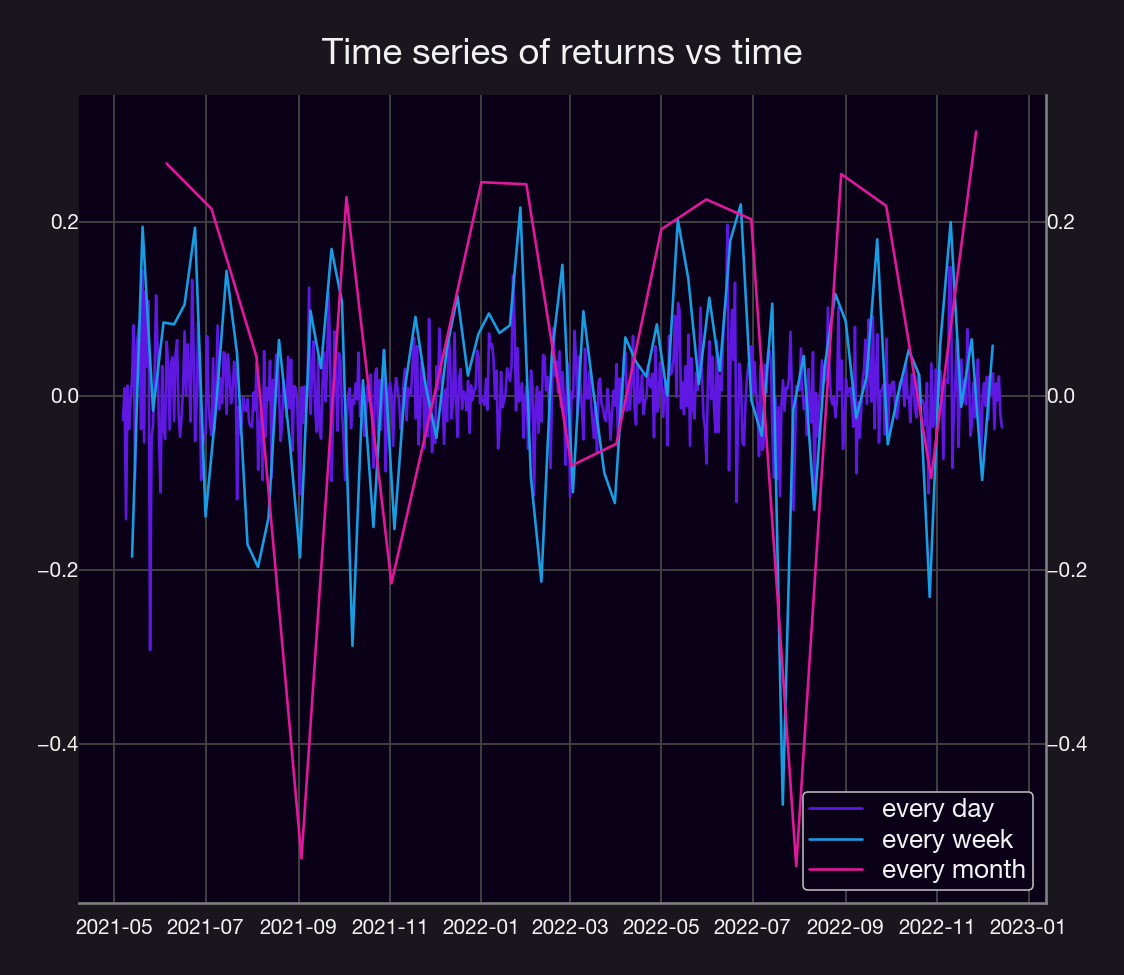

In [5]:
#time series
plt.plot(res1['times'],res1['returns'],label='every day')
plt.plot(res7['times'],res7['returns'],label='every week')
plt.plot(res30['times'],res30['returns'],label='every month')
plt.title('Time series of returns vs time')
plt.legend()
plt.show()


We now present the cummulative returns of these strategies. in the figure below. As we can see, in this particular setting, the more frequent strategy tends to outperform the other ones. Once again, this should not be very surprising, as more frequent calibrations means that the positions are "following" the price more closely, and as such, reducing the risk of being outside of bounds. 


**Remark (on re-deployment)** *Notice that in the plots below we **did not** take into account the cost to close and redeploy a position. These costs will, in practice, ofset the cummulative retuns.*




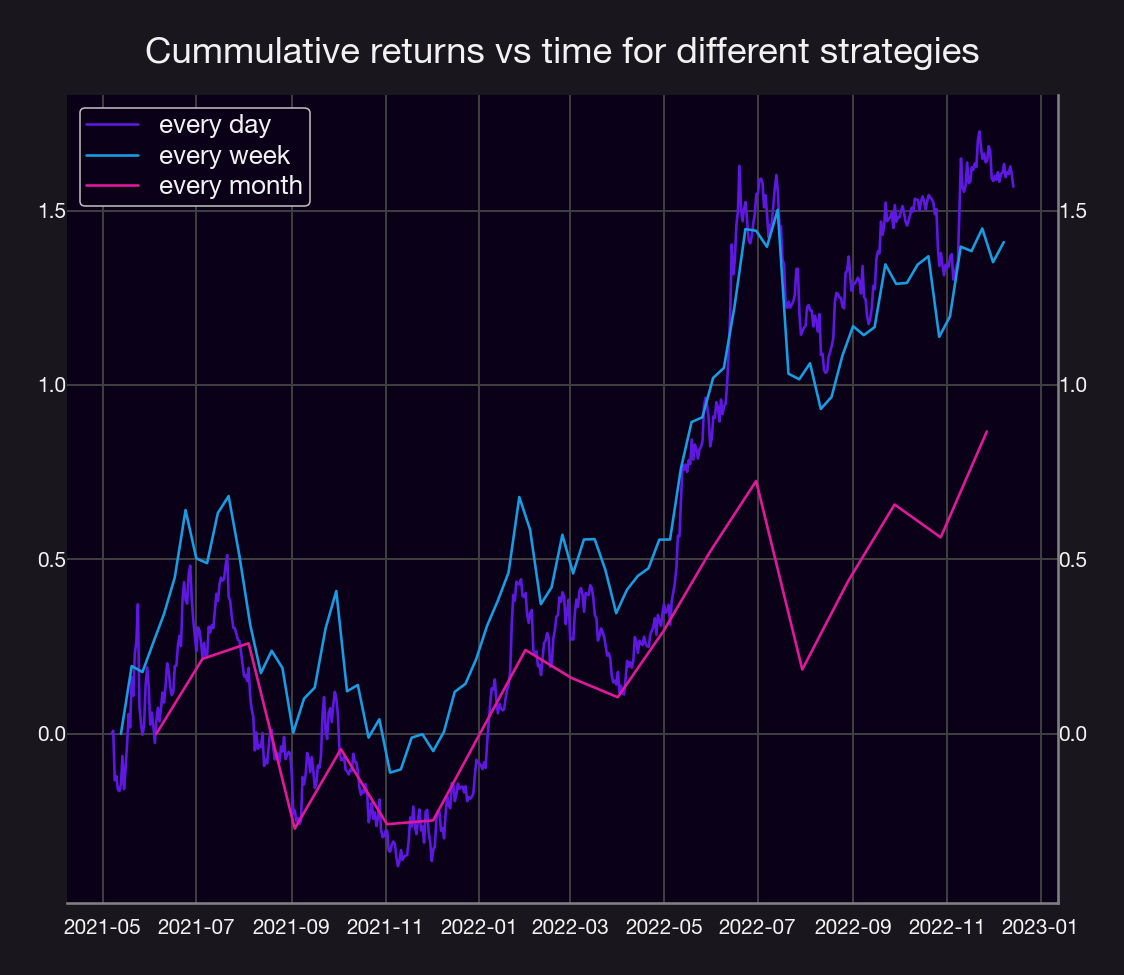

In [6]:
# cumulative
plt.plot(res1['times'],np.cumsum(res1['returns'])-res1['returns'][0],label='every day')
plt.plot(res7['times'],np.cumsum(res7['returns'])-res7['returns'][0],label='every week')
plt.plot(res30['times'],np.cumsum(res30['returns'])-res30['returns'][0],label='every month')
plt.title('Cummulative returns vs time for different strategies')
plt.legend()
plt.show()

Lastly, we present a histogram of the returns, as required in the prompt. As we can see, the monthly stratey seems to have a widder left tail, which signals that it is more propense to negative returns. The weekly strategy seems to concentrate around 0, with a sligh right skew, signaling positive returns. The daily strate seems to be more centered than the weekly one

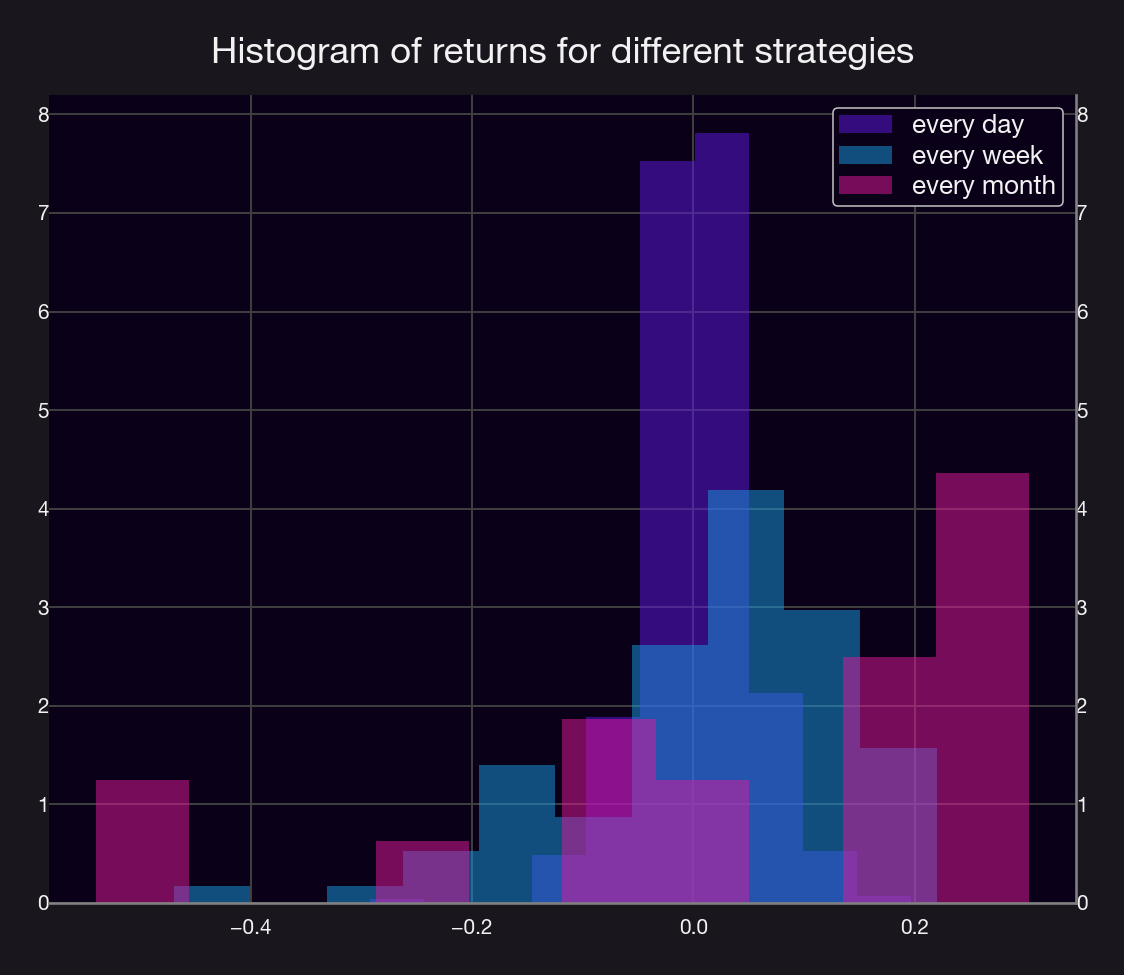

In [7]:
# histograms
plt.hist(res1['returns'],density=True,label='every day',alpha=0.5)
plt.hist(res7['returns'],density=True,label='every week',alpha=0.5)
plt.hist(res30['returns'],density=True,label='every month',alpha=0.5)
plt.title('Histogram of returns for different strategies')
plt.legend()
plt.show()

#### Q2: Describing these returns:

We now proceed to perform a a quick description of the data at hand. In particular, we fucus on computing 
- average return, 
- max loss, 
- average loss, 
- win rate, average gain,
- max gain

We begin by presenting a table with the descriptive statistics of the returns for each strategy:

**NB**  *I don't know if the table below counts as "publication quality" but given that I am using markdown/jupyter it is probably on of the better looking graphs one can get in this environment.* 

In [8]:
table=pd.DataFrame(pd.DataFrame({'Daily':res1['returns']}).describe())
table['Weeky']=pd.DataFrame({'weekly':res7['returns']}).describe()
table['Monthly']=pd.DataFrame({'Monthly':res30['returns']}).describe()
table.drop(index='count')

,Daily,Weeky,Monthly
mean,0.002624,0.014754,0.059671
std,0.048041,0.125420,0.257780
min,-0.292152,-0.469708,-0.540415
25%,-0.024831,-0.047070,-0.067724
50%,0.002900,0.034520,0.202853
75%,0.029022,0.092667,0.235630
max,0.196521,0.219975,0.303711


From the table above, we can see that all methods have positive, small, average returns. This is not too surprising, given the results in the *cummulative returns** figure. However, as we can see, as the redeployment window increases, so does the standard deviation of the returns, as shown in the first figure. We can also see here (as well as from the first figure) that as we increase the redeployment window, we increase the "spread" of the returns defined by $\max-\min$. 

We now produce a similar table for the maximum losses and wins (i.e., the descriptive statistics of the time series in the second picture).  

In [9]:
c1=np.cumsum(res1['returns'])-res1['returns'][0]
c7=np.cumsum(res7['returns'])-res7['returns'][0]
c30=np.cumsum(res30['returns'])-res30['returns'][0]
table=pd.DataFrame(pd.DataFrame({'Daily':np.cumsum(res1['returns'])-res1['returns'][0]}).describe())
table['Weeky']=pd.DataFrame({'weekly':np.cumsum(res7['returns'])-res7['returns'][0]}).describe()
table['Monthly']=pd.DataFrame({'Monthly':np.cumsum(res30['returns'])-res30['returns'][0]}).describe()
table.drop(index='count')

,Daily,Weeky,Monthly
mean,0.542678,0.639077,0.231964
std,0.652288,0.485221,0.333545
min,-0.379281,-0.111299,-0.271958
25%,-0.011785,0.226312,-0.001340
50%,0.306804,0.510775,0.214770
75%,1.247090,1.072469,0.480469
max,1.726509,1.501948,0.866761


Lastly,  given a return $R_i$, and a cummulative return $C_i$ $i\in\{\text{daily,weekly,monthly}\},$ we define the $\textsf{Win Rate}_i$
\begin{align}
\textsf{Win Rate}_i=\frac{\textsf{number of returns with ($R_i>0$)}}{\textsf{Total number of transactions}}
\end{align}
and the *proportion underwater* $\mathsf{u}_i$ of the $i^\text{th}$ strategy as 

\begin{align}
\textsf{u}_i=\frac{\textsf{number of returns with ($C_i$<0)}}{\textsf{Total number of transactions}}
\end{align}


This yileds the results in the table below. 


|                       | Daily                 | Weekly              | Monthly            |
|-----------------------|-----------------------|---------------------|--------------------|
| $\textsf{Win Rate}_i$ | 0.524701873935264     | 0.6626506024096386  | 0.6842105263157895 |
| $u_i$                 | 0.25383304940374785   | 0.07228915662650602 | 0.2631578947368421 |

This seems to be in agreement to the plots in the previous question. 

As we have seen, the re-deployment frequency can have a pretty noticeable effect in the overall behaviour of the position. 

#### Q3: Price and volatility


We now plot the price of the pool and its time-averaged volatility. Throughout this section and the next one we will use [Simple Moving Averages](https://en.wikipedia.org/wiki/Moving_average)


In [10]:
print('💻 computing prices ....')
df=cp.pool
BASE_UNITS=1.0001
DIGITS_USDC=6
DIGITS_ETH=18
print('getting price from ticks')
df['price']=(BASE_UNITS**df['tick'])*10**(DIGITS_USDC-DIGITS_ETH)
df['price_inv']=1./((BASE_UNITS**df['tick'])*10**(DIGITS_USDC-DIGITS_ETH))
print('getting returns from ticks')
df['returns']=BASE_UNITS**df['tick'].diff()
df['returns_inv']=1./((BASE_UNITS**df['tick'].diff()))

print('getting price weighted averages')
df['SMA30']=df.rolling('30D',on='block_timestamp').mean()['price']
df['SMA7']=df.rolling('7D',on='block_timestamp').mean()['price']
df['SMA1']=df.rolling('1D',on='block_timestamp').mean()['price']
df['SMA30_inv']=df.rolling('30D',on='block_timestamp').mean()['price_inv']
df['SMA7_inv']=df.rolling('7D',on='block_timestamp').mean()['price_inv']
df['SMA1_inv']=df.rolling('1D',on='block_timestamp').mean()['price_inv']

print('getting volatilities weighted averages')
df['volSMA30']=df.rolling('30D',on='block_timestamp').mean()['returns']
df['volSMA7']=df.rolling('7D',on='block_timestamp').std()['returns']
df['volSMA1']=df.rolling('1D',on='block_timestamp').std()['returns']
print('Done!')

💻 computing prices ....
getting price from ticks
getting returns from ticks
getting price weighted averages
getting volatilities weighted averages
Done!


📈 plotting...


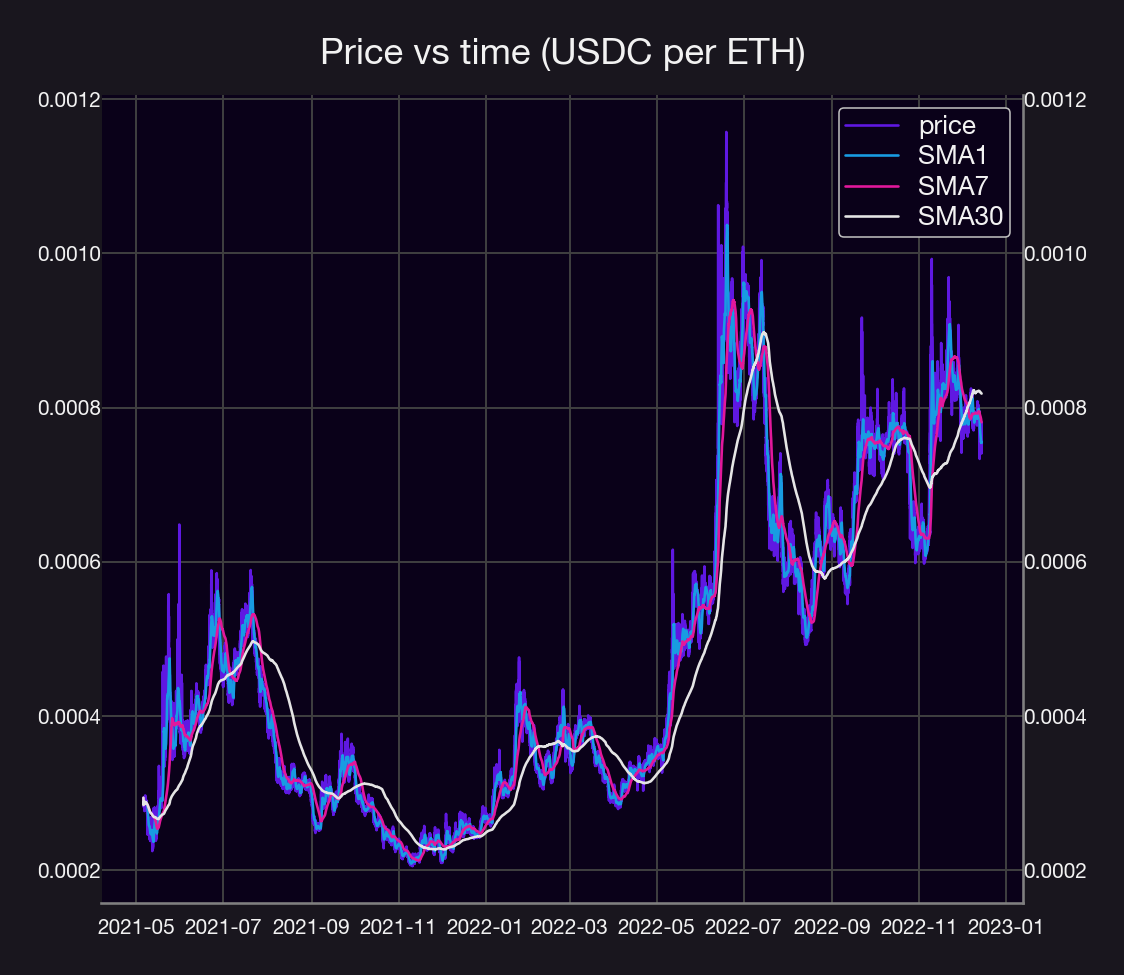

In [11]:
print('📈 plotting...')
fig, ax = plt.subplots()
ax.plot(df['block_timestamp'],df['price'],label='price')
ax.plot(df['block_timestamp'],df['SMA1'],label='SMA1')
ax.plot(df['block_timestamp'],df['SMA7'],label='SMA7')
ax.plot(df['block_timestamp'],df['SMA30'],label='SMA30')

# Rotate and align the tick labels so they look better.
# Use a more precise date string for the x axis locations in the toolbar.
ax.set_title('Price vs time (USDC per ETH)')
plt.legend()
plt.show()

This figure, while accurate is not super intuitive as we are more used to having USD(C) as a num\'eraire. We can obtain the historical ETH price ( in terms of USDC) below. 

📈 plotting...


/var/folders/wz/tdmt_j1d4_d876mcvb5071480000gn/T/ipykernel_12291/525284860.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.autofmt_xdate()


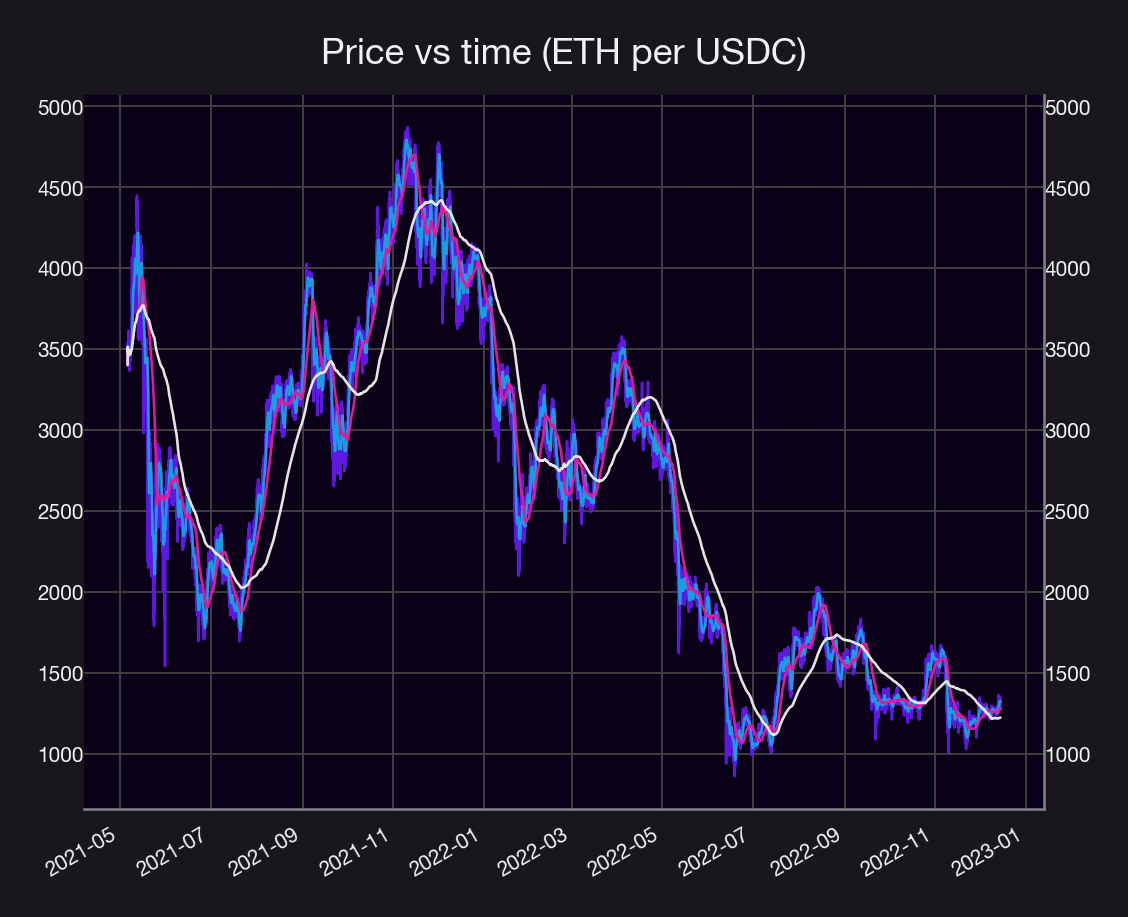

In [12]:
print('📈 plotting...')
fig, ax = plt.subplots()
ax.plot(df['block_timestamp'],df['price_inv'],label='price')
ax.plot(df['block_timestamp'],df['SMA1_inv'],label='SMA1')
ax.plot(df['block_timestamp'],df['SMA7_inv'],label='SMA7')
ax.plot(df['block_timestamp'],df['SMA30_inv'],label='SMA30')# Rotate and align the tick labels so they look better.
fig.autofmt_xdate()
# Use a more precise date string for the x axis locations in the toolbar.
ax.set_title('Price vs time (ETH per USDC)')
plt.show()

We now focus on the log returns and the weighted volatilities

📈 plotting...


/var/folders/wz/tdmt_j1d4_d876mcvb5071480000gn/T/ipykernel_12291/3525646942.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.autofmt_xdate()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


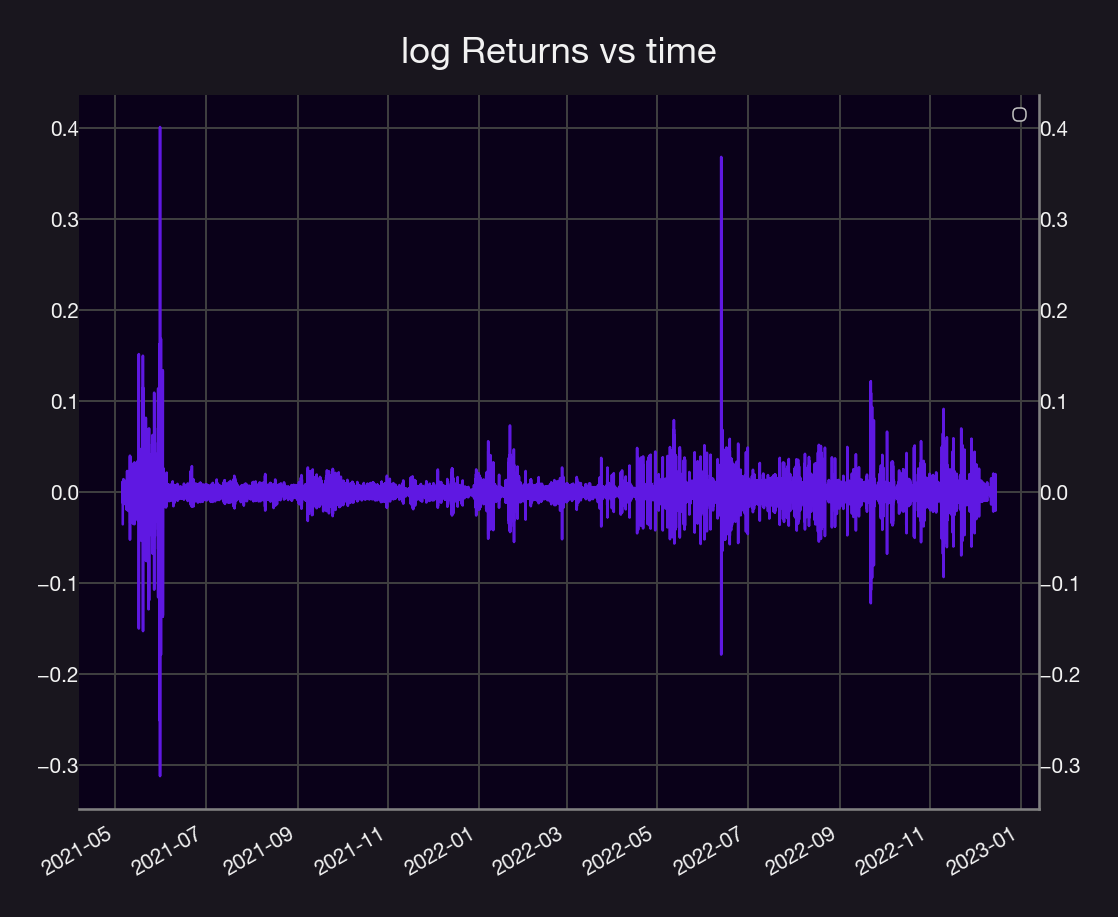

In [13]:
vol_f=np.log(1.0001)
df['logReturns']=vol_f*df['tick'].diff().dropna()
print('📈 plotting...')
fig, ax = plt.subplots()
ax.plot(df['block_timestamp'],df['logReturns'])
# Rotate and align the tick labels so they look better.
fig.autofmt_xdate()
# Use a more precise date string for the x axis locations in the toolbar.
ax.set_title('log Returns vs time')
plt.legend()
plt.show()

Given the returns, we can compute the **Realized volatility** $\mathsf{RV}_k$ for the $k^\text{th}$ moving average $k\in\{1,7,30\}$ days as 

\begin{aligned}
\mathsf{RV}_k=\left[\text{SMA}_k\left(\log\left(\frac{P_{i_t}}{P_{i_{t-1}}}\right)^2\right)\right]^{1/2}
\end{aligned}
with $\log\left(\frac{P_{i_t}}{P_{i_{t-1}}}\right)$ the log returns over the whole time series, as shown above, and $\text{SMA}_k$ the simple moving average. 
We compute this below. Notice the scaling factor to adjust volatility to one year.


In [14]:
scaling=(365*len(df)/588)**0.5
df['lr2']=(365*len(df)/588)**0.5*df['logReturns']**2
df['v2SMA1']=df.rolling('1D',on='block_timestamp').mean()['lr2']
df['v2SMA7']=df.rolling('7D',on='block_timestamp').mean()['lr2']
df['v2SMA30']=df.rolling('30D',on='block_timestamp').mean()['lr2']

/var/folders/wz/tdmt_j1d4_d876mcvb5071480000gn/T/ipykernel_12291/2080483524.py:6: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.autofmt_xdate()


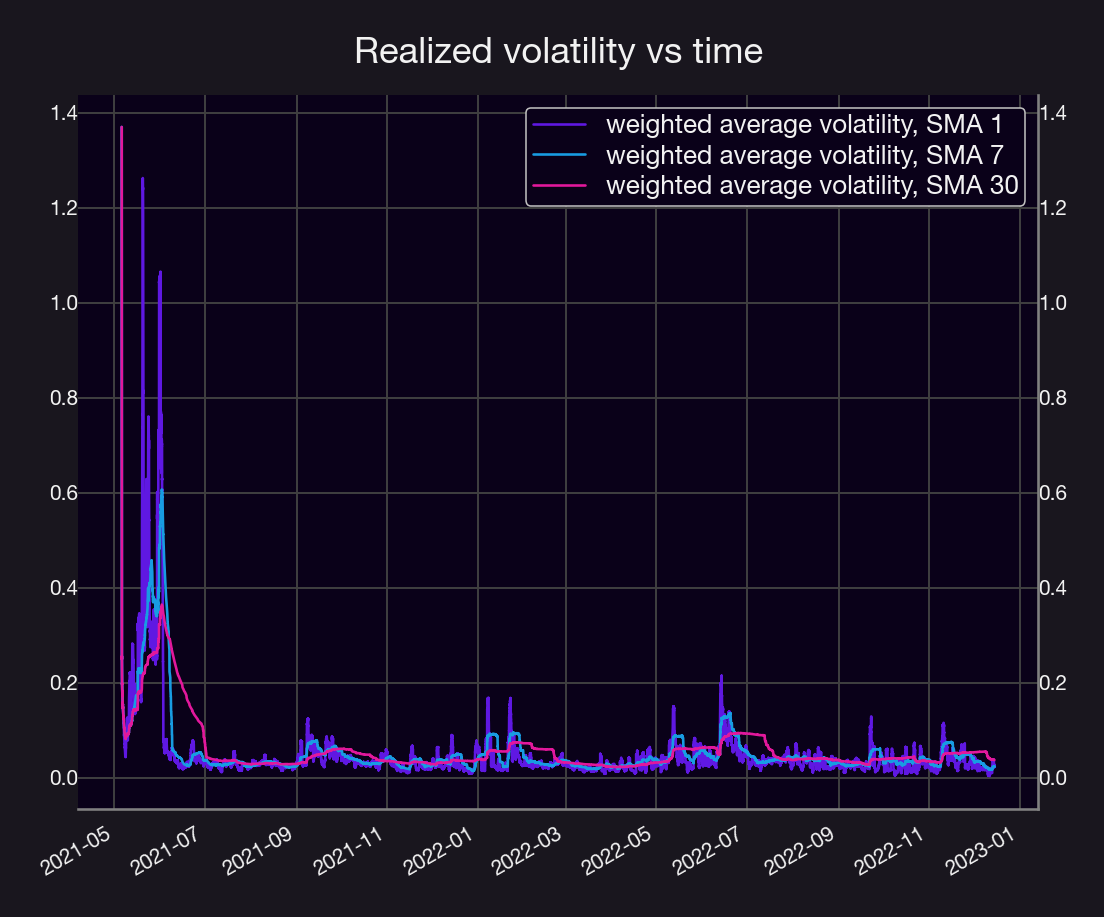

In [15]:
fig, ax = plt.subplots()
ax.plot(df['block_timestamp'],df['v2SMA1']**0.5,label='weighted average volatility, SMA 1')
ax.plot(df['block_timestamp'],df['v2SMA7']**0.5,label='weighted average volatility, SMA 7')
ax.plot(df['block_timestamp'],df['v2SMA30']**0.5,label='weighted average volatility, SMA 30')
# Rotate and align the tick labels so they look better.
fig.autofmt_xdate()
# Use a more precise date string for the x axis locations in the toolbar.
ax.set_title('Realized volatility vs time')
plt.legend()
plt.show()



#### Q4 

Lstly, we investigate the correlations between the volatility and the returns. To that end, we put everything into the same datasets

In [16]:

df_aux1=pd.DataFrame({'block_timestamp':res1['times'],
         'returns':res1['returns'],
         'cummulative':c1
        })
df_aux7=pd.DataFrame({'block_timestamp':res7['times'],
         'returns':res7['returns'],
         'cummulative':c7
        })

df_aux30=pd.DataFrame({'block_timestamp':res30['times'],
         'returns':res30['returns'],
         'cummulative':c30
        })

df1=pd.merge(df,df_aux1,on='block_timestamp')
df7=pd.merge(df,df_aux7,on='block_timestamp')
df30=pd.merge(df,df_aux30,on='block_timestamp')

📈 plotting...


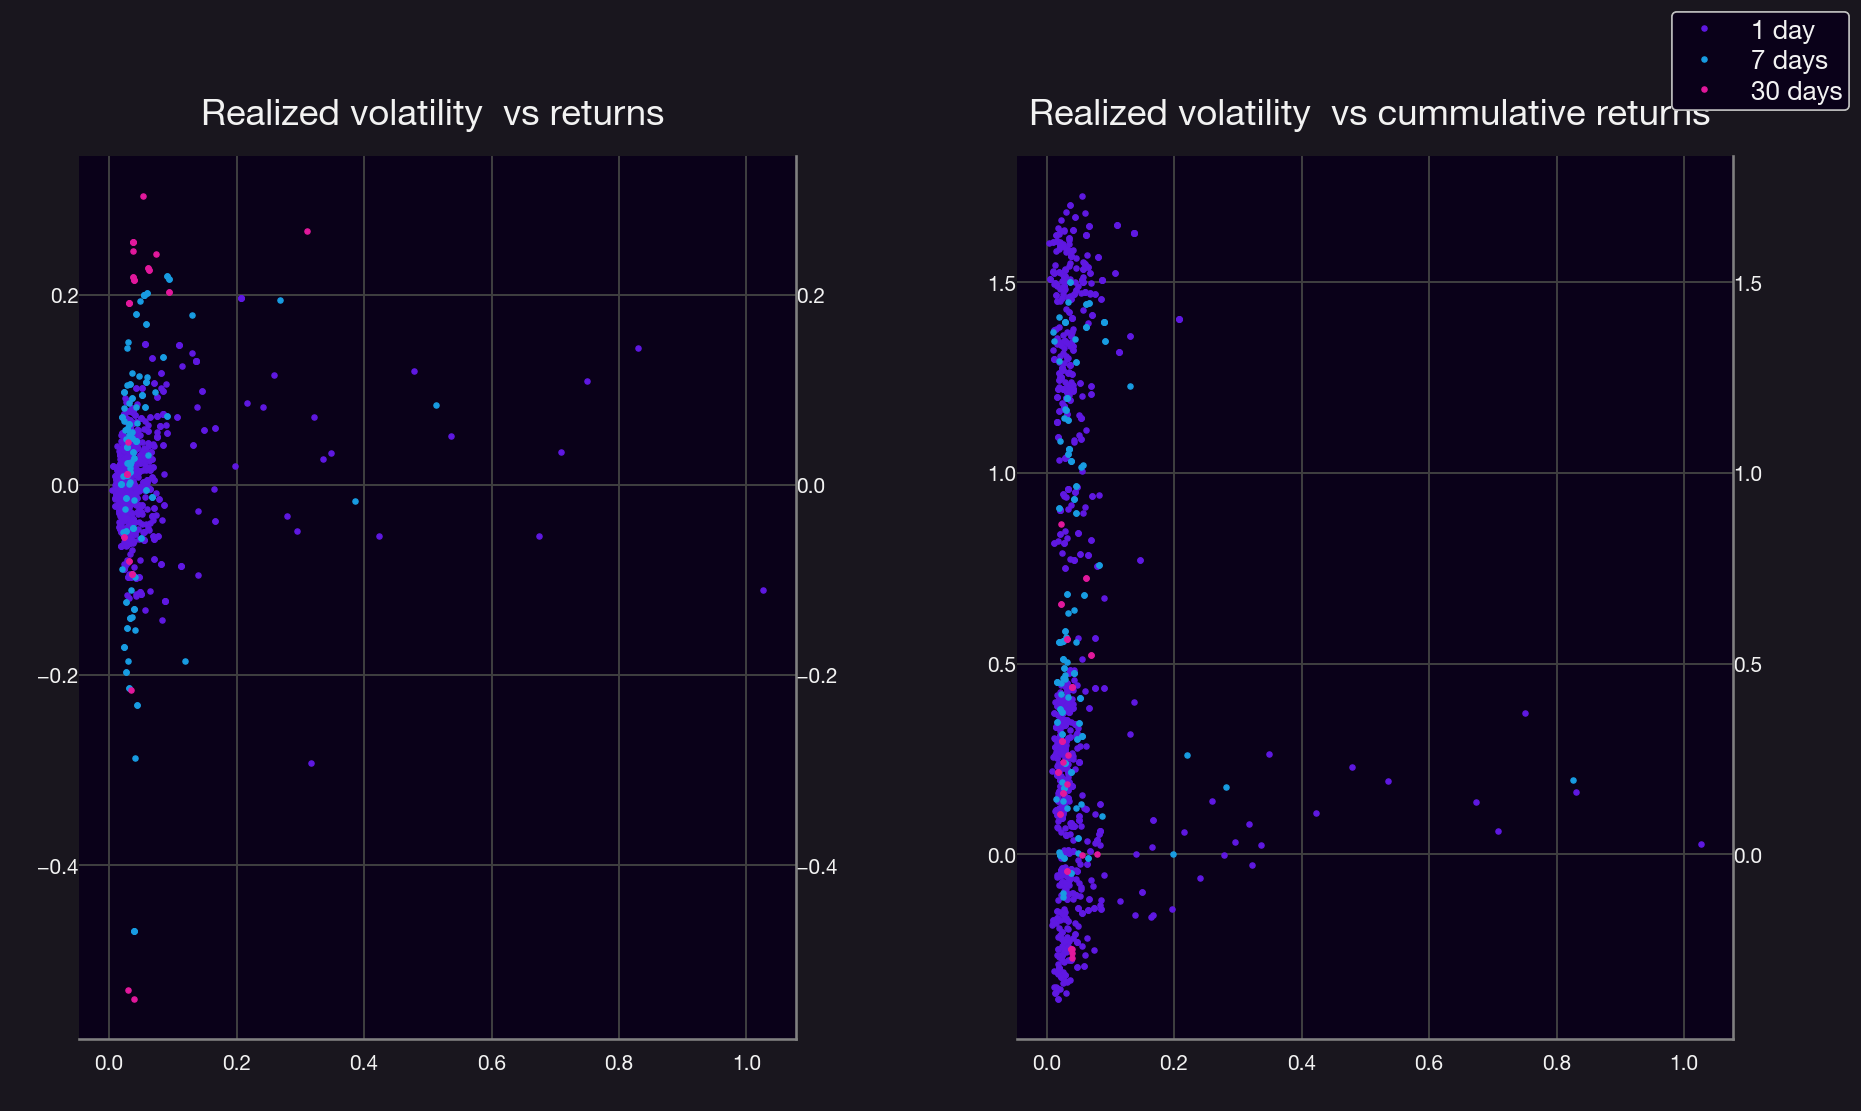

In [17]:
print('📈 plotting...')
fig,ax=plt.subplots(1,2,figsize=(5,3))
ax[0].plot(df1['v2SMA1']**0.5,df1['returns_y'],'.',label='1 day')
ax[0].plot(df7['v2SMA7']**0.5,df7['returns_y'],'.',label='7 days')
ax[0].plot(df30['v2SMA30']**0.5,df30['returns_y'],'.',label='30 days')
ax[0].set_title('Realized volatility  vs returns ')
fig.legend()

ax[1].plot(df1['v2SMA1']**0.5,df1['cummulative'],'.')
ax[1].plot(df7['v2SMA1']**0.5,df7['cummulative'],'.')
ax[1].plot(df30['v2SMA1']**0.5,df30['cummulative'],'.')
ax[1].set_title('Realized volatility  vs cummulative returns ')
fig.legend()


However, there must be something wrong here. I'd expect volatility to really affect the returns...

#### Future work

Clearly, the returns obtained from deploying any given strategy will depend on several factors, such as redeployment frequency, width, etc. 

- Exploring this in more detail is certainly interest. One such way could be as follows. Given a position $q$ a strategy $s$ and some objective function $\ell(s;q)$, one could try to find $s^*\in S$ (for some set of admissible strategies $S$), such that $\ell(s^*,q)$ is optimal in any suitable sense (i.e., profit maximization, variance minizitaion etc). 
- Another path also worth exploring is the effect that opening and closing positions would have on the returns.
- It would be interesting to compare returns for the same position deployed across different pools. 
